La información es obtenida de dos fuentes:

- Instituto Nacional de Estadística y Geografía (INEGI) en:

https://www.inegi.org.mx/programas/accidentes/#datos_abiertos

- Instituto Internacional de Ciencia de Datos, respecto a la información recopilada por la aseguradora AXA:

https://i2ds.org/datos-abiertos/



Accidentes de Tránsito Terrestre en Zonas Urbanas y Suburbanas (ATUS)

La recolección de datos para la elaboración de la estadística de accidentes de tránsito terrestre en zonas urbanas y suburbanas inició en el año 1928, y los procedimientos para su obtención se han modificado paulatinamente.

Esta estadística mide la siniestralidad del transporte a nivel nacional, y se genera a partir del acopio y procesamiento de los datos alusivos a los accidentes ocurren en zonas no federales. Esta información contribuyó a la planeación, organización del transporte y la prevención de accidentes.

Obtener:

- Accidentes viales por década
- Fallecimientos por accidentes viales por rango de edad
- Semana del año donde ocurren más accidentes de acuerdo con la serie de tiempo
- Estadística de más accidentes por día de la semana, hora del día, fin de semana, y/o día festivo.
- Promedio de accidentes y su posible predicción por Poisson.
- Tipo de accidente en cada semana (atropellamiento, volcamiento, choque contra objetos, etc.)
- Principales causas de accidentes: [ProyectoPuente - Causas](https://www.uniradioinforma.com/policiaca/hermosillo-reporta-ligera-disminucion-accidentes-viales-n822053)

In [35]:
%pip install missingno seaborn folium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# (Pending) Create the requirements.txt for the venv
import numpy as np
import pandas as pd
import requests
import zipfile as zf
import os, io
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Descarga de Datos

# Datos de Open Meteo

In [37]:
url_weather = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 29.1026,
	"longitude": -110.9773,
	"hourly": ["temperature_2m", "rain", "showers", "visibility"],
}
weather_response = requests.get(url_weather, params=params)

In [38]:
json_file = weather_response.json()
hourly = json_file['hourly']
df_weather = pd.DataFrame(hourly)
df_weather.head()

,time,temperature_2m,rain,showers,visibility
0,2025-10-11T00:00,34.0,0.0,0.0,53700.0
1,2025-10-11T01:00,31.1,0.0,0.0,34100.0
2,2025-10-11T02:00,29.8,0.0,0.0,35500.0
3,2025-10-11T03:00,28.6,0.0,0.0,31700.0
4,2025-10-11T04:00,28.1,0.0,0.0,29500.0


In [39]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            168 non-null    object 
 1   temperature_2m  168 non-null    float64
 2   rain            168 non-null    float64
 3   showers         168 non-null    float64
 4   visibility      168 non-null    float64
dtypes: float64(4), object(1)
memory usage: 6.7+ KB


In [40]:
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather['year'] = df_weather['time'].dt.year
df_weather['month'] = df_weather['time'].dt.month
df_weather['day'] = df_weather['time'].dt.day
df_weather['hour'] = df_weather['time'].dt.hour
df_weather = df_weather.drop('time', axis=1)
df_weather.head()

,temperature_2m,rain,showers,visibility,year,month,day,hour
0,34.0,0.0,0.0,53700.0,2025,10,11,0
1,31.1,0.0,0.0,34100.0,2025,10,11,1
2,29.8,0.0,0.0,35500.0,2025,10,11,2
3,28.6,0.0,0.0,31700.0,2025,10,11,3
4,28.1,0.0,0.0,29500.0,2025,10,11,4


In [41]:
df_weather.to_csv('../data/raw/weather_data.csv', index=False)

## Other Dataset

In [42]:
# Download URL
url_inegi = 'https://www.inegi.org.mx/contenidos/programas/accidentes/datosabiertos/conjunto_de_datos_atus_anual_csv.zip' # INEGI
url_axa = 'https://files.i2ds.org/OpenDataAxaMx/incidentes_viales_2023_axa.zip' # AXA

In [43]:
datos_axa = '../data/raw/AXA/'
folders = ['../data/raw', '../data/interim', datos_axa]
for folder in folders:
  if not os.path.exists(folder):
    os.makedirs(folder)
  else:
    print(f"Folder {folder} already created.")

Folder ../data/raw already created.
Folder ../data/interim already created.
Folder ../data/raw/AXA/ already created.


## AXA México 2023 Dataset

Dataset download, 2023 year selection, and integrity rules.

In [44]:
response = requests.get(url_axa)
# The response comes with a Bytes series due to a ZIP file
with zf.ZipFile(io.BytesIO(response.content), 'r') as zip_object:
    zip_object.extractall(datos_axa)

In [45]:
dfs = []  # List to store dataframes

# Extract the column names to set the headers for those files not starting with "df"
for file in os.listdir(datos_axa):
  if file.startswith('df_'):
    header = pd.read_csv(os.path.join(datos_axa, file), nrows=1).columns
    break

for file in os.listdir(datos_axa):
    # Rule to assure only csv
    if file.endswith('.csv'):
        filepath = os.path.join(datos_axa, file)
        try:
            if file.startswith('df_'):
                df = pd.read_csv(filepath)
                print(f"Created DataFrame for {file} with shape {df.shape}")
                dfs.append(df)
            else:
                df = pd.read_csv(filepath)
                df.columns = header
                print(f"Created DataFrame for {file} with shape {df.shape}")
                dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    else:
        print(f"Error reading the file {file}")

Created DataFrame for df_Seguridad_Vial_concatenado_Agosto_2023.csv with shape (30389, 44)
Created DataFrame for df_Seguridad_Vial_concatenado_Diciembre_2023.csv with shape (29531, 44)
Created DataFrame for df_Seguridad_Vial_concatenado_Julio_2023.csv with shape (28042, 44)
Created DataFrame for df_Seguridad_Vial_concatenado_Junio_2023.csv with shape (29228, 44)
Created DataFrame for df_Seguridad_Vial_concatenado_Noviembre_2023.csv with shape (3027, 44)
Created DataFrame for df_Seguridad_Vial_concatenado_Octubre_2023.csv with shape (29833, 44)
Created DataFrame for df_Seguridad_Vial_concatenado_Septiembre_2023.csv with shape (29874, 44)
Created DataFrame for Seguirad_vial_concatenado_Mayo_2023.csv with shape (28116, 44)
Created DataFrame for Seguridad_Vial_concatenado_Abril_2023.csv with shape (23831, 44)
Created DataFrame for Seguridad_Vial_concatenado_Enero_2023.csv with shape (24319, 44)
Created DataFrame for Seguridad_Vial_concatenado_Febrero_2023.csv with shape (23040, 44)
Created

In [46]:
# One df preview
dfs[4].head(3)

,SINIESTRO,LATITUD,LONGITUD,CODIGO POSTAL,CALLE,COLONIA,CAUSA SINIESTRO,TIPO VEHICULO,COLOR,MODELO,...,VOLCADURA,PERDIDA TOTAL,CONDUCTOR DISTRAIDO,FUGA,ALCOHOL,MOTOCICLETA,BICICLETA,SEGURO,TAXI,ANIMAL
0,2410556,16.906725,-99.825554,39750.0,Carretera Federal Mexico Acapulco 2,Emiliano Zapata,NaN,Auto,AZUL,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2411363,16.866338,-99.900250,39350.0,Avenida Baja California 165,Progreso,NaN,Auto,PLATA,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2411705,16.870932,-99.898541,39560.0,Bernal Díaz del Castillo 71,Progreso,NaN,Auto,GRIS,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Filtered df to select only Sonora
df_AXA = pd.concat(dfs, ignore_index=True)
print("Shape of the original DataFrame:", df_AXA.shape)
df_AXA_sonora = df_AXA[df_AXA['ESTADO'] == 'Sonora'].copy()
print("Shape of the filtered DataFrame for Sonora:", df_AXA_sonora.shape)

Shape of the original DataFrame: (306648, 44)
Shape of the filtered DataFrame for Sonora: (9828, 44)


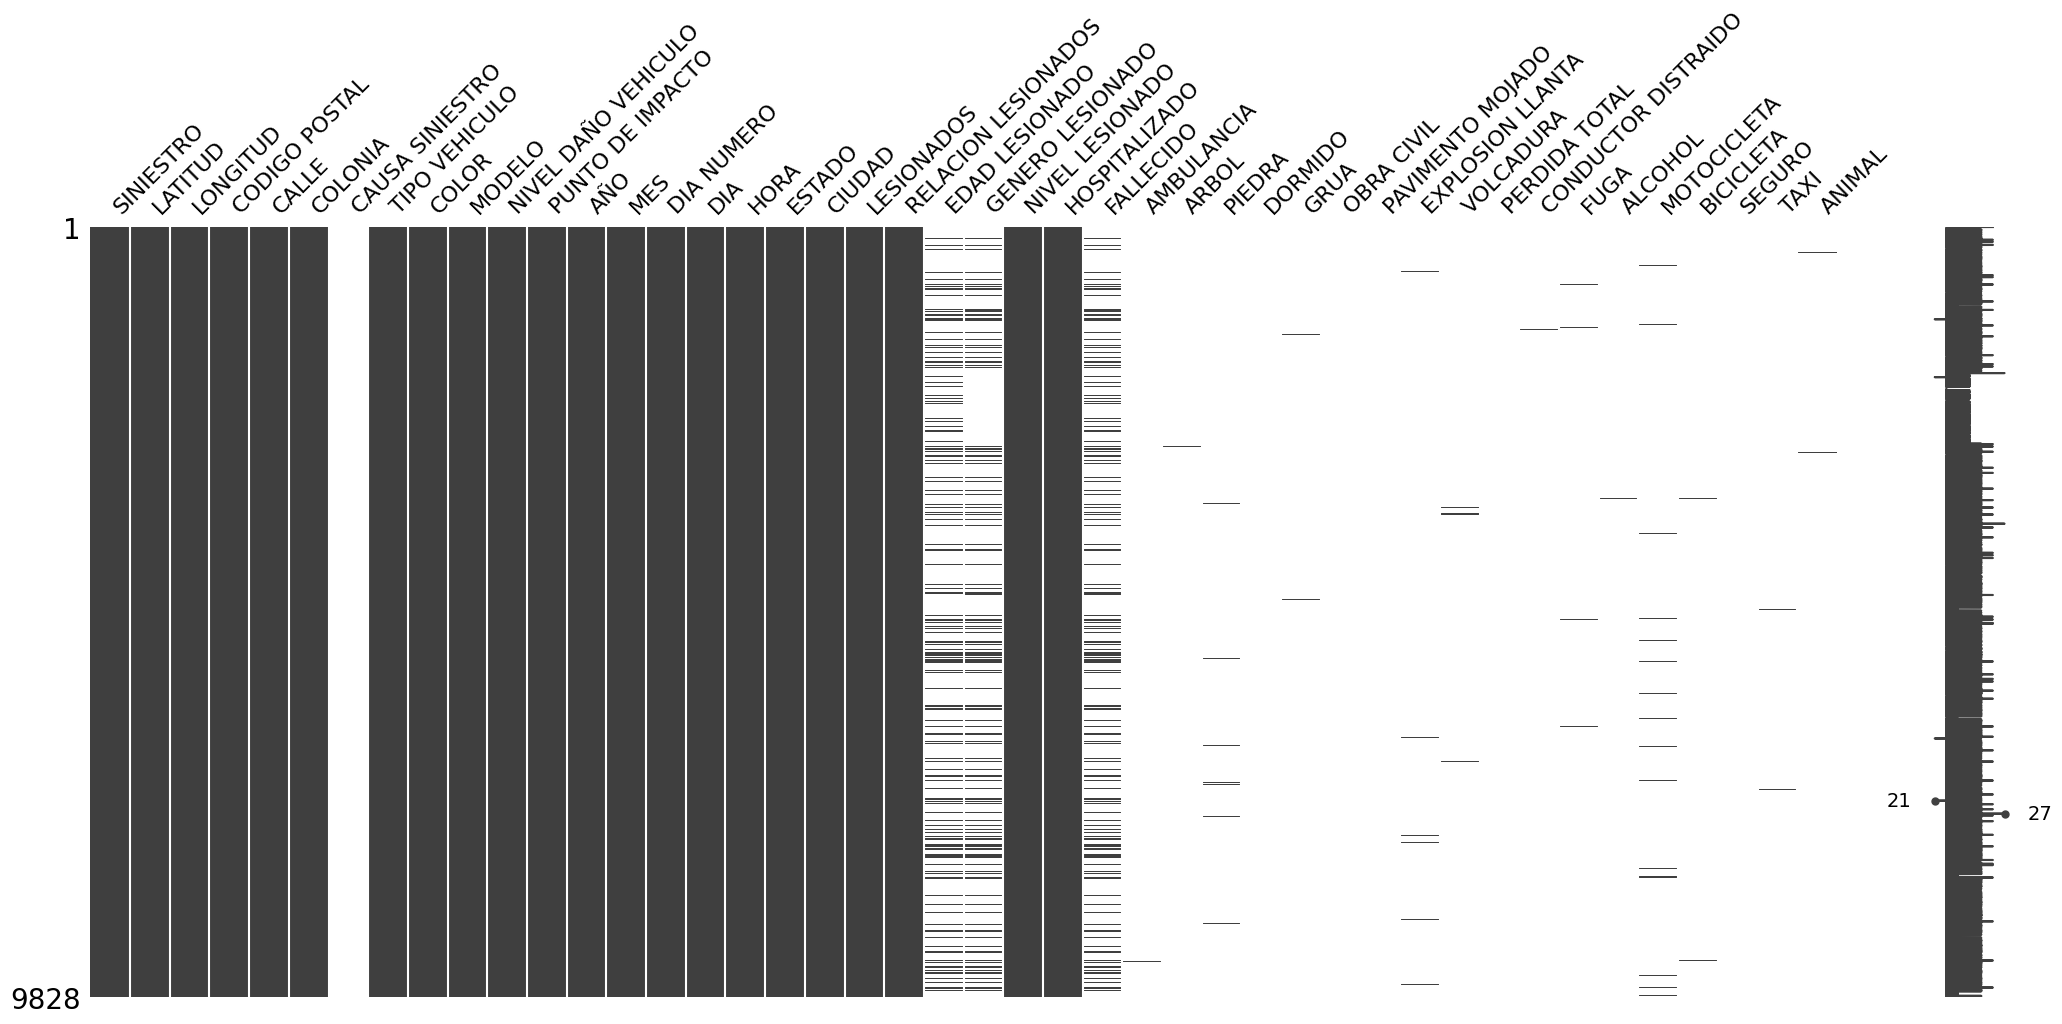

In [48]:
# Look up for missing values
msno.matrix(df_AXA_sonora)
plt.show()

Watching the matrix for missing data, we can observe a MAR (Missing at Random) distribution due to the nature of the dataset. Each row only register a accident, but not everyone has fatalities implies, or some specific objects.

Let's look for the total emptiness of each column.

In [49]:
emptiness = df_AXA_sonora.isna().sum()
print(emptiness)

SINIESTRO                 0
LATITUD                   0
LONGITUD                  0
CODIGO POSTAL             0
CALLE                     0
COLONIA                   1
CAUSA SINIESTRO        9828
TIPO VEHICULO             0
COLOR                     0
MODELO                    3
NIVEL DAÑO VEHICULO       0
PUNTO DE IMPACTO          0
AÑO                       0
MES                       0
DIA NUMERO                0
DIA                       0
HORA                      0
ESTADO                    0
CIUDAD                    0
LESIONADOS                0
RELACION LESIONADOS       0
EDAD LESIONADO         7842
GENERO LESIONADO       7987
NIVEL LESIONADO           0
HOSPITALIZADO             0
FALLECIDO              7818
AMBULANCIA             9823
ARBOL                  9822
PIEDRA                 9750
DORMIDO                9820
GRUA                   9816
OBRA CIVIL             9828
PAVIMENTO MOJADO       9827
EXPLOSION LLANTA       9756
VOLCADURA              9785
PERDIDA TOTAL       

Analyzing the empty values, there are some columns with 99% emptiness. So, this columns will be drop from the df.

In [50]:
universe = df_AXA_sonora.shape[0]
for index, value in emptiness.items():
  emptiness_value = value / universe
  if emptiness_value > 0.99:
    try:
      df_AXA_sonora.drop(columns=[index], inplace=True)
      print(f"Dropping column {index} with {emptiness_value:.2%} missigness")
    except Exception as e:
      print(f"Error dropping column or already dropped for {index}: {e}")

Dropping column CAUSA SINIESTRO with 100.00% missigness
Dropping column AMBULANCIA with 99.95% missigness
Dropping column ARBOL with 99.94% missigness
Dropping column PIEDRA with 99.21% missigness
Dropping column DORMIDO with 99.92% missigness
Dropping column GRUA with 99.88% missigness
Dropping column OBRA CIVIL with 100.00% missigness
Dropping column PAVIMENTO MOJADO with 99.99% missigness
Dropping column EXPLOSION LLANTA with 99.27% missigness
Dropping column VOLCADURA with 99.56% missigness
Dropping column PERDIDA TOTAL with 100.00% missigness
Dropping column CONDUCTOR DISTRAIDO with 99.84% missigness
Dropping column FUGA with 99.29% missigness
Dropping column ALCOHOL with 99.99% missigness
Dropping column BICICLETA with 99.87% missigness
Dropping column SEGURO with 99.98% missigness
Dropping column TAXI with 99.85% missigness
Dropping column ANIMAL with 99.56% missigness


In [51]:
dropped_columns = df_AXA.shape[1] - df_AXA_sonora.shape[1]
print(f"Dropped columns: {dropped_columns}")

Dropped columns: 18


Now we have dropped some columns, leaving only 18.

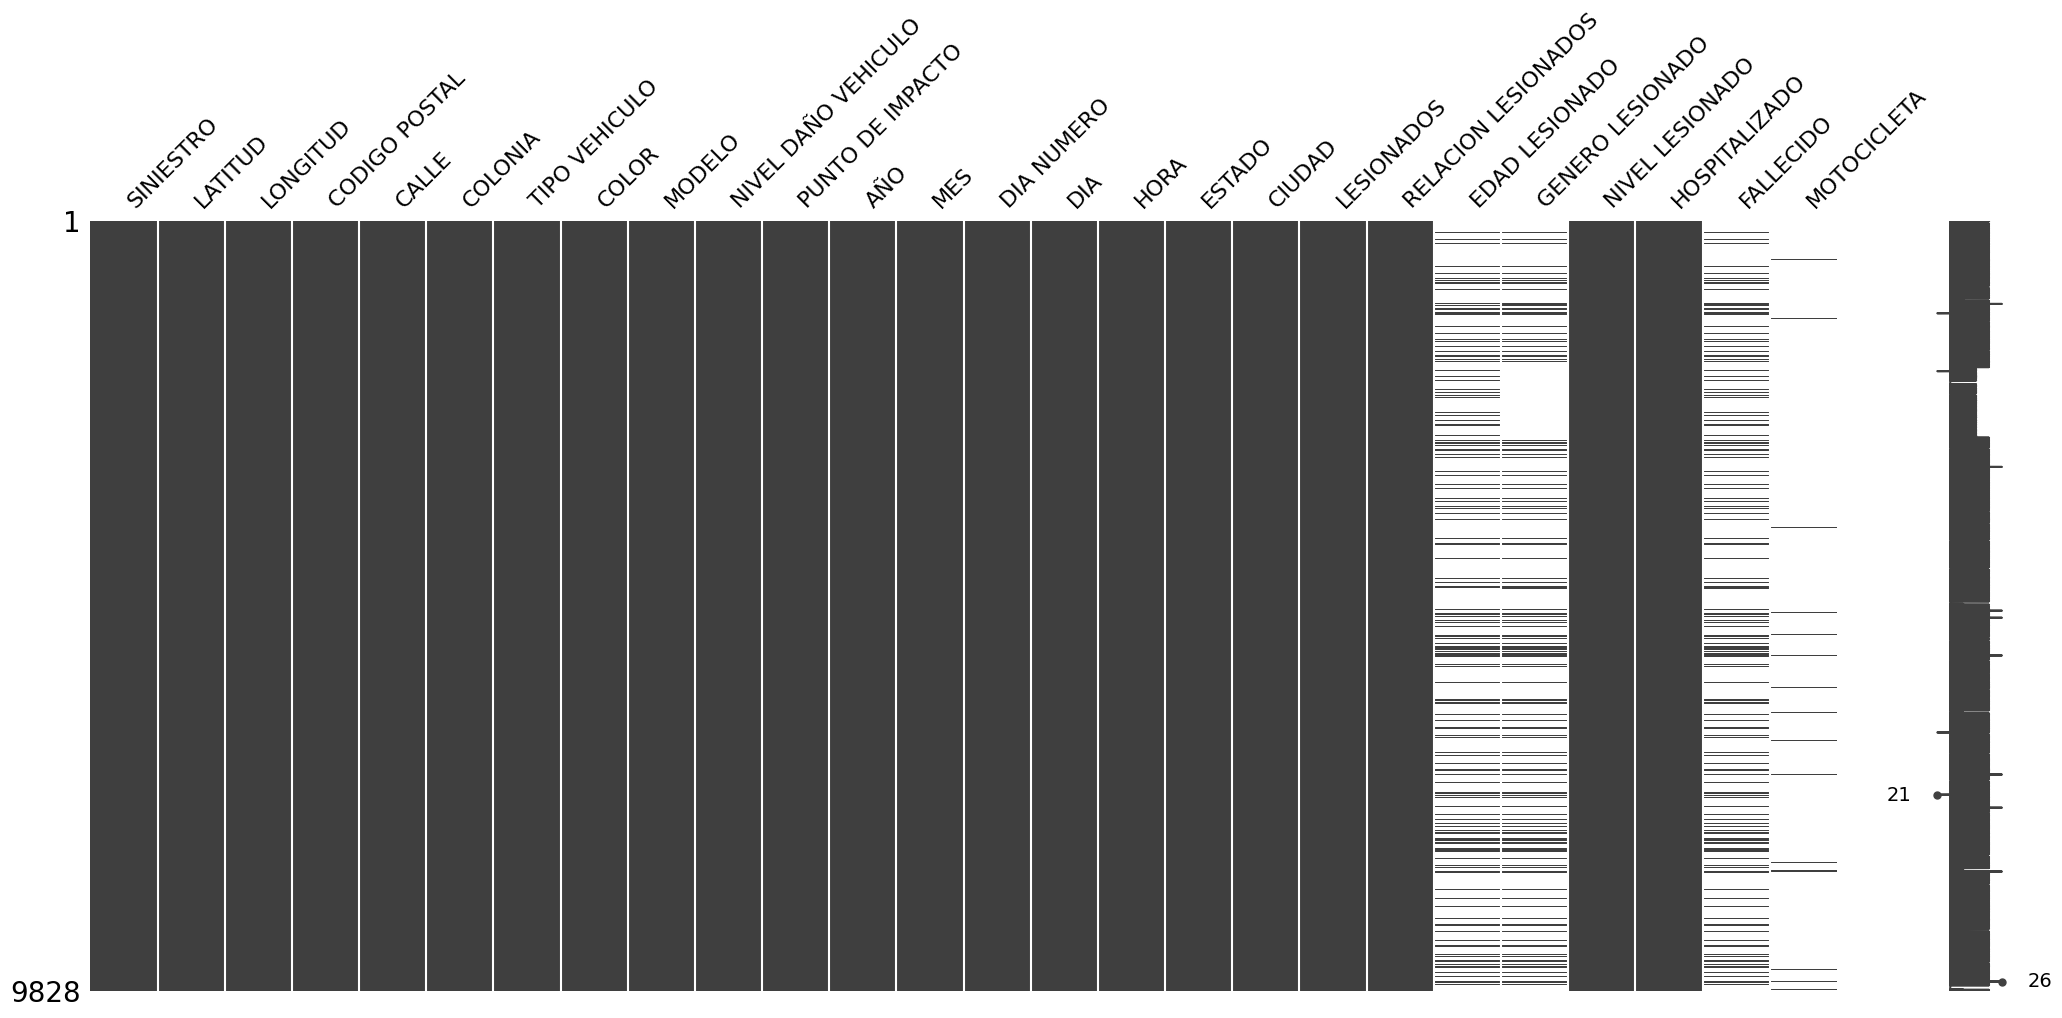

In [52]:
msno.matrix(df_AXA_sonora)
plt.show()

In [53]:
df_AXA.columns

Index(['SINIESTRO', 'LATITUD', 'LONGITUD', 'CODIGO POSTAL', 'CALLE', 'COLONIA',
       'CAUSA SINIESTRO', 'TIPO VEHICULO', 'COLOR', 'MODELO',
       'NIVEL DAÑO VEHICULO', 'PUNTO DE IMPACTO', 'AÑO', 'MES', 'DIA NUMERO',
       'DIA', 'HORA', 'ESTADO', 'CIUDAD', 'LESIONADOS', 'RELACION LESIONADOS',
       'EDAD LESIONADO', 'GENERO LESIONADO', 'NIVEL LESIONADO',
       'HOSPITALIZADO', 'FALLECIDO', 'AMBULANCIA', 'ARBOL', 'PIEDRA',
       'DORMIDO', 'GRUA', 'OBRA CIVIL', 'PAVIMENTO MOJADO', 'EXPLOSION LLANTA',
       'VOLCADURA', 'PERDIDA TOTAL', 'CONDUCTOR DISTRAIDO', 'FUGA', 'ALCOHOL',
       'MOTOCICLETA', 'BICICLETA', 'SEGURO', 'TAXI', 'ANIMAL'],
      dtype='object')

## INEGI 2024 Dataset

In [54]:
response = requests.get(url_inegi)
print(type(response))

<class 'requests.models.Response'>


In [66]:
datos_inegi = '../data/raw/ATUS/'
if not os.path.exists(datos_inegi):
    os.makedirs(datos_inegi)

with zf.ZipFile(io.BytesIO(response.content), 'r') as zip_object:
    # Extrae todos los archivos del ZIP a la carpeta de destino
    zip_object.extractall(datos_inegi)

Con el método BytesIO del módulo io, se trata la respuesta del HTTP (una secuencia de bytes) como un archivo en memoria. Esto permite a zipfile.Zipfile leer el contenido directo desde memoria.

In [67]:
df_inegi = pd.read_csv(datos_inegi + 'conjunto_de_datos/atus_anual_2024.csv')
display(df_inegi.head())

,COBERTURA,ID_ENTIDAD,ID_MUNICIPIO,ANIO,MES,ID_HORA,ID_MINUTO,ID_DIA,DIASEMANA,URBANA,...,PEATMUERTO,PEATHERIDO,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,NEMUERTO,NEHERIDO,CLASACC,ESTATUS
0,Municipal,1,1,2024,1,2,25,1,lunes,Accidente en intersección,...,0,0,0,0,0,0,0,0,Sólo daños,Cifras Corregidas
1,Municipal,1,1,2024,1,3,40,1,lunes,Accidente en intersección,...,0,0,0,0,0,0,0,0,Sólo daños,Cifras Corregidas
2,Municipal,1,1,2024,1,4,37,1,lunes,Accidente en intersección,...,0,1,0,0,0,0,0,0,No fatal,Cifras Corregidas
3,Municipal,1,1,2024,1,5,0,1,lunes,Accidente en intersección,...,0,0,0,0,0,0,0,0,Sólo daños,Cifras Corregidas
4,Municipal,1,1,2024,1,6,45,1,lunes,Accidente en intersección,...,0,0,0,0,0,0,0,0,Sólo daños,Cifras Corregidas


In [57]:
df_inegi.shape

(390627, 45)

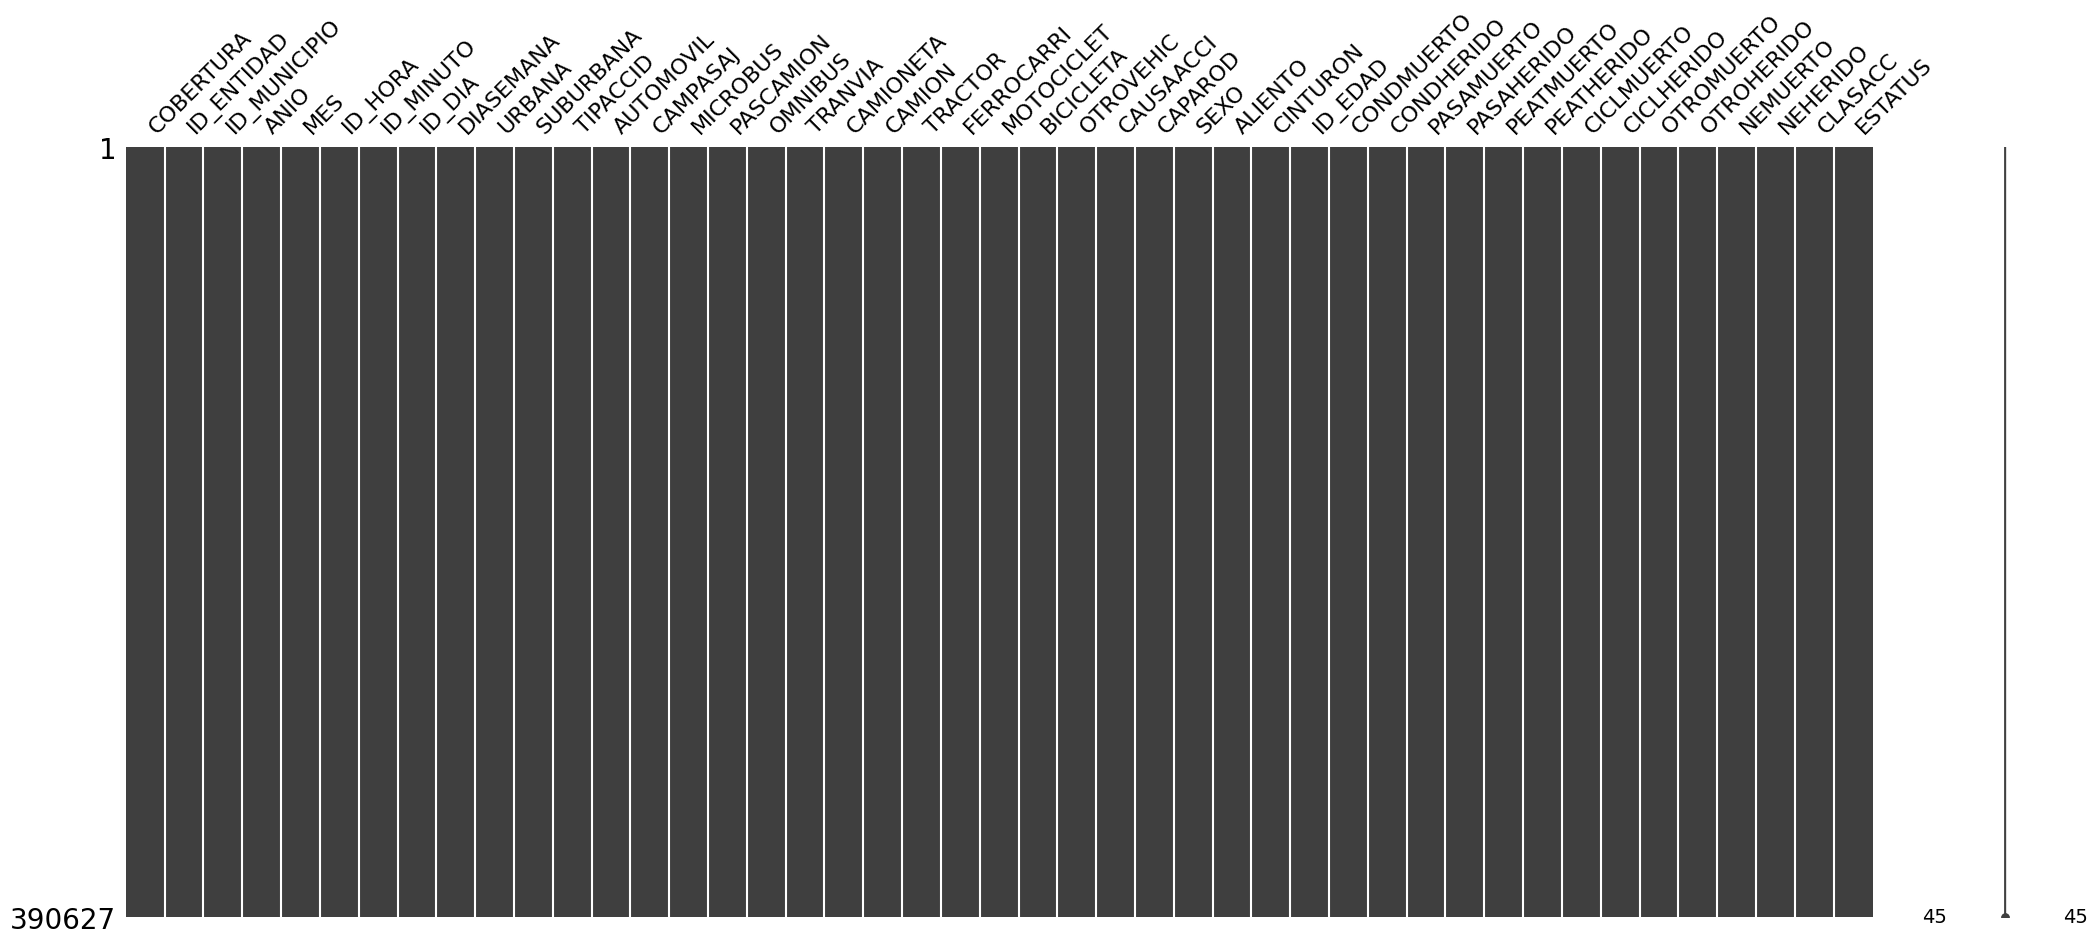

In [58]:
msno.matrix(df_inegi)
plt.show()

For the INEGI dataset, there are no empty columns.

# Exploratory Data Analysis

## INEGI Age Range

En Sonora ha dicho que se propone imponer un límite de edad de 70 años para conducir un automóvil.

¿Qué edades suelen tener accidentes? ¿Debería haber un límite real en la edad para permitir la conducción de un automóvil debido a la seguridad vial?

In [59]:
df_generaciones = df_inegi[df_inegi['ID_EDAD'] != 99].copy()
df_generaciones['generacion'] = np.floor(df_generaciones['ID_EDAD'] / 10) * 10

La clasificación del rango de edad tiene dos puntos importantes:

- `0` para aquellos que se fugan
- `99` para quellos sin edad especificada

In [60]:
df_generaciones['generacion'].value_counts(normalize=True)

generacion
20.0    0.226625
30.0    0.218748
40.0    0.157332
0.0     0.154119
50.0    0.103773
10.0    0.060396
60.0    0.053294
70.0    0.020604
80.0    0.004361
90.0    0.000748
Name: proportion, dtype: float64

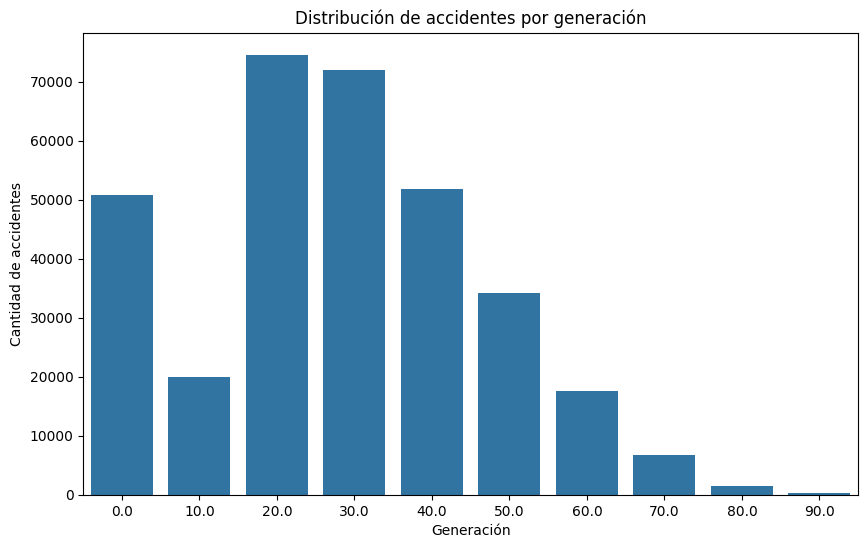

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(x='generacion', data=df_generaciones)
plt.xlabel('Generación')
plt.ylabel('Cantidad de accidentes')
plt.title('Distribución de accidentes por generación')
plt.show()

As the figure shows, the main age range in accidents are 20' (20-29) and 30' (30-39).

## Mapa de siniestros AXA

In [62]:
import folium
from folium.plugins import MarkerCluster

In [63]:
df_AXA_geopoints = df_AXA[['LONGITUD','LATITUD', 'NIVEL DAÑO VEHICULO', 'PUNTO DE IMPACTO', 'LESIONADOS']]

In [64]:
center = [df_AXA_geopoints['LATITUD'].mean(), df_AXA_geopoints['LONGITUD'].mean()]
m = folium.Map(location=center, zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)

for index, row in df_AXA_geopoints.iterrows():
  popup_text = f"""
        <b>Point Info</b><br>
        --------------------<br>
        <b>Lat:</b> {row['LATITUD']:.4f}<br>
        <b>Lon:</b> {row['LONGITUD']:.4f}<br>
        <b>Nivel daño vehicular:</b> {row['NIVEL DAÑO VEHICULO']}<br>
        <b>PUNTO DE IMPACTO:</b> {row['PUNTO DE IMPACTO']}<br>
        <b>LESIONADOS:</b> {row['LESIONADOS']}
  """
  popup = folium.Popup(popup_text, max_width=600)
  '''
  folium.Marker(
          location=[row['LATITUD'], row['LONGITUD']],
          popup=popup_text,
          tooltip="Click to see info"
          ).add_to(marker_cluster)
  '''
m.save('./data/mapa_siniestros_AXA.html')

In [65]:
# Display the map
m